# Machine Learning in a Nutshell with scikit-learn
    
## Unsupervised Learning: Clustering


by [__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/) and [Konstantin Ziegler (konstantin.ziegler@uni-passau.de)](http://zieglerk.net) based on examples from the [scikit-learn documentation](http://scikit-learn.org/stable/)

__License__

This work is licensed under a [CC BY 3.0](http://creativecommons.org/licenses/by/3.0/)


## Outline

1. Overview
2. Partition-based, iterative Clustering - K-Means
3. Hierarchical Agglomerative Clustering - Ward
4. Density based Clustering - DBSCAN
5. Evaluation Measures

# Overview

Unsupervised learning aims to find hidden structures in data. 

* **Clustering** identifies groups of similar data samples. Data samples should be maximize intra group similarity and mininmize intergroup similarity.

* **Dimensionality Projection** aims to project a high-dimensional space into a low dimensional space

* **Manifold Learning** aims to indentify lower-dimensional subspaces that contain a particular structure of data samples

In this notebook, we cover the basics applications with scikit-learn. For the underlying theory and more, see the references at the end of this page.

## Clustering


**Clustering**: Group $n$ data samples into $k$ clusters such that the similarity among samples **within a cluster is maximized** and the similarity **between cluster is minimized** .

## Input Data

In scikit-learn, input to a clustering can take two different forms:

1. As a matrix consisting of `n_samples` and `n_features`
2. As a similarity (distance/dissimilarity) matrix of shape `[n_samples, n_samples]`

Given a **similarty measure** or **distance metric** between samples, the first approach can always be converted in the second approach. 


## Overview of clustering methods in scikit-learn

The following image gives an overview over scikit learn methods.

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">

Image taken from [scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html). You can find the generating code under `modules/plot_cluster_comparison.py`.

# Data

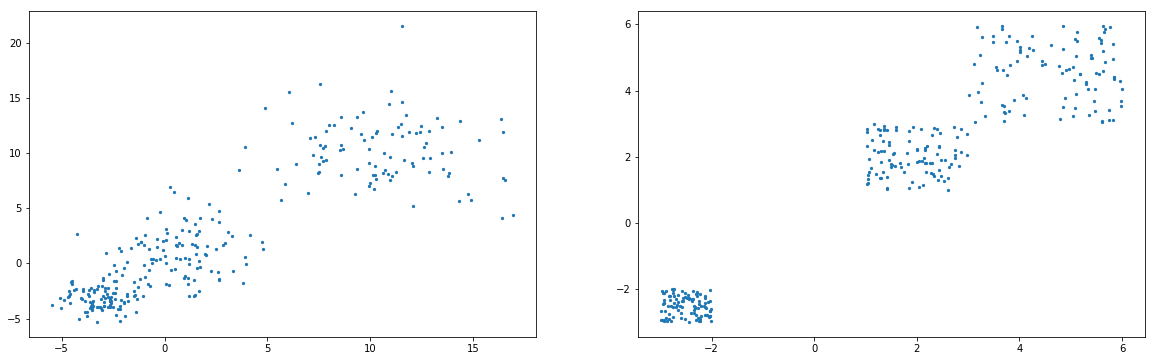

In [146]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

np.random.seed(42)

#create 3 normally distributed clusters 
n_points = 100
normal2D= np.array(np.random.randn(n_points,2))*2+1
normal2D= np.append(normal2D,np.random.randn(n_points,2)*3+10,axis=0)
normal2D= np.append(normal2D,np.random.randn(n_points,2)*1-3,axis=0)
normal2D_y = [0] * n_points + [1] * n_points + [2] * n_points

# create 3 uniform distributed clusters
n_points = 100
uniform2D= np.array(np.random.ranf((n_points,2))*2+1)
uniform2D= np.append(uniform2D,np.random.ranf((n_points,2))*3+3,axis=0)
uniform2D= np.append(uniform2D,np.random.ranf((n_points,2))*1-3,axis=0)
uniform2D_y = [0] * n_points + [1] * n_points + [2] * n_points

# generate blobs (normally distributed)
centers = [[1, 1], [-1, -1], [1, -1]]
blobs_X, blobs_y = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
# rescale to mean 0 and variance 1b
blobs_X = StandardScaler().fit_transform(blobs_X)

# generate nested
moons_X, moons_y = datasets.make_moons(500, noise=0.20)

# Load IRIS dataset (3 types of flowers)
dataset = datasets.load_iris()
iris_X = dataset.data
iris_y = dataset.target

# Load MNIST Digits dataset (10 digits)
digits = datasets.load_digits(n_class=10)
digits_X = digits.data
digits_y = digits.target
n_samples, n_features = digits_X.shape

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.scatter(normal2D[:,0], normal2D[:,1], s=5)
plt.subplot(1,2,2)
plt.scatter(uniform2D[:,0], uniform2D[:,1], s=5)
plt.show()

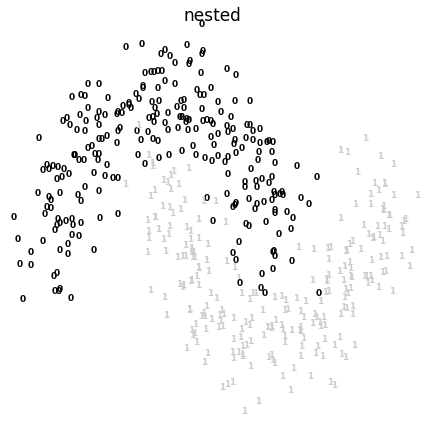

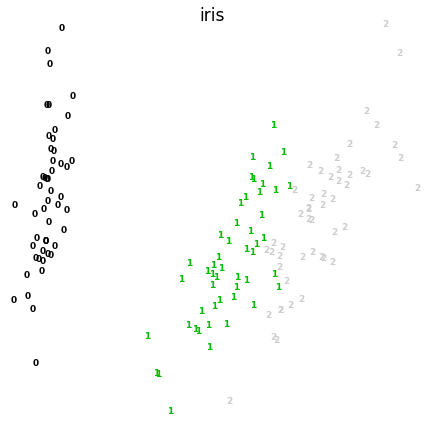

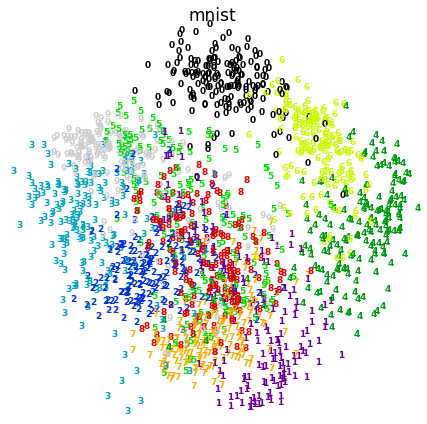

In [147]:
# Visualize the clustering
def plot_labeled_dataset(X, y, label, title=None, proj=PCA):
    if X.shape[1] > 2:
        X_red = proj(n_components=2).fit_transform(X)
    else:
        X_red = X
    c_r = max(label)
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 6))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(label[i] / float(c_r)),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
    

#iris_X_red = PCA(n_components=2).fit_transform(iris_X)
#digits_X_red = PCA(n_components=2).fit_transform(digits_X)
plot_labeled_dataset(moons_X, moons_y, moons_y, 'nested')
plot_labeled_dataset(iris_X_red, iris_y, iris_y, 'iris')
plot_labeled_dataset(digits_X_red, digits_y, digits_y, 'mnist')



# K-Means Clustering

In this exercise you should develop and apply the k-means algorithm and evaluate it visually on the digits dataset created above.

k-means is an iterative, partitioning clustering algorithm that minimizes

$$J(X,C)=\sum_{i=0}^{|X|}\min_{\mu_j\in C}(||x_i-\mu_j||^2)$$

with $X$ being the samples, $C$ being the number of clusters and $\mu_j$ being the representative of a cluster $c_j\in C$.

So basically it searches for a set of clusters that minimizes the squared distances of all data points to the cluster representative. In case of k-**means** the cluster representative is the mean vector of its data points

### Algorithm Sketch

1. **Initalise** $C$ by selecting $k$ cluster representatives $\mu_1 \ldots \mu_k$
2. **Partition** the data according to the cluster representatives, i.e. assign $x_i$ to the cluster $argmin_{\mu_j\in \{\mu_1 \ldots \mu_k\}}(||x_i-\mu_j||^2) $
3. **Recalculate** the cluster representatives $\mu_1 \ldots \mu_k$ as $\mu_j=\frac{1}{|c_j|}\sum_{x_i \in c_j}x_i$
4. If the partition does not change or a number of iteration is exceeded, stop. Otherwise go to 2.

### Some Algorithmic Properties

* k-means is very sensitive to the starting points $\mu_i$
* k-means needs to know the number of clusters a-priori
* k-means can be applied on one sample per iteration (i.e. assignment and recalculation per sample), which is called online (or stochastic) k-means. Going over all samples before recalculating the representatives is called (full-)batch. There a differences in convergence rate and stopping criterion.
* k-means finds only cluster of approximately similar size that induce a [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram)

<a href="http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html" target="_blank"><img src="https://pythonprogramming.net/static/images/unsupervised-learning/plot_kmeans_digits_001.png"></a>
(image from scikit Learn. You can find the generating code under `modules/plot_kmeans_digits.py`)

In [148]:
data = np.random.randn(1000, 2)

def choose_centroids(X, k):
    # return k vectors (centroids) shape: (k, n_dim)

def find_nearest_centroids(X, centroids, fast=True):
    # return a list of length X.shape[0]
    # Each element in the list corresponds to the index of the closest cluster an example should be assigned to.

def update_centroids(X, centroids, nearest_centroids):
    # return the updated centroids. shape (k, n_dim)

/Users/johannesjurgovsky/Work/Internals/Lehre/DataScience/venv/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Stopping after 21 iterations due to convergence.


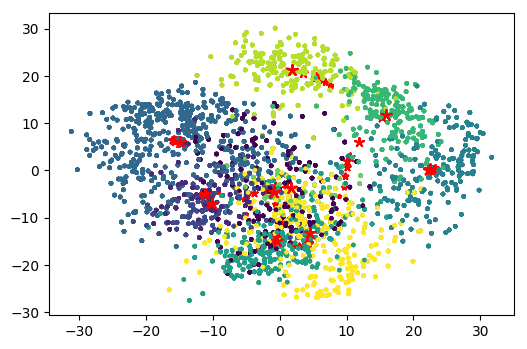

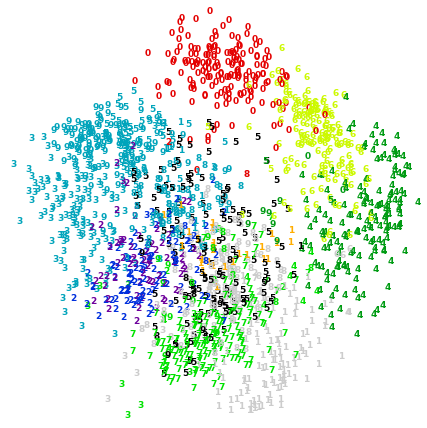

In [149]:
plt.ion()
fig, ax = plt.subplots(dpi=100)
fig.show()
fig.canvas.draw()

def do_KMeans(X, k, n_iter_max=100, plot_interval=2):
    
    # Only for visualization purposes
    data_proj = PCA(n_components=2).fit(X)

    c = 0
    cluster_assigment_old = np.array([-1] * X.shape[0])
    
    # STEP 1 : Pick initial centroids
    centroids = choose_centroids(X, k)
    
    # Iterate k-Means n_iter_max-times
    while c < n_iter_max:
        
        # STEP 2: Find the closest centroid (its index) for each example
        cluster_assignment = find_nearest_centroids(X, centroids)

        # Stop iterating if cluster assignment did not change
        if np.all(cluster_assignment == cluster_assigment_old):
            print("Stopping after %d iterations due to convergence." % c)
            return centroids, cluster_assignment
        
        # STEP 3: Update centroids: new centroid position = mean over examples that have been assigned to this centroid
        centroids = update_centroids(X, centroids, cluster_assignment)
        
        cluster_assigment_old = cluster_assignment
        c += 1
        
        # Fancy plotting every now and then (only with %matplotlib notebook)
        if c % plot_interval == 0:
            _X = data_proj.transform(X)
            _c = data_proj.transform(centroids)
            ax.scatter(_X[:, 0], _X[:, 1], c=cluster_assignment, s=5)
            ax.scatter(_c[:, 0], _c[:, 1], c='r', marker=(5, 2), s=c * (300./n_iter_max))
            fig.canvas.draw()
             
    return centroids, cluster_assignment_old

k_means, assignment = do_KMeans(digits_X, 10)
plot_labeled_dataset(digits_X, digits_y, assignment)

### Usage in scikit-learn

* Module: `from sklearn.cluster import KMeans`
* Instantiate a object `kmeans = KMeans(....parameters...)`
* Fit to data: `model = kmeans.fit(data)`
* Assign data to cluster: `model.predict (data)`

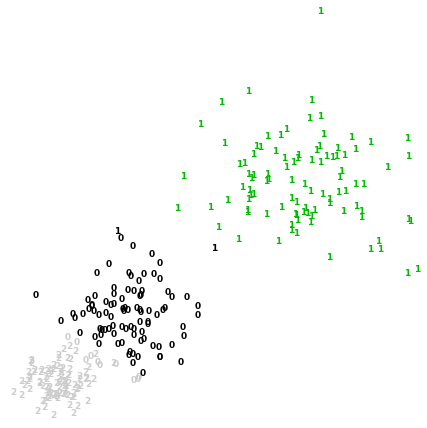

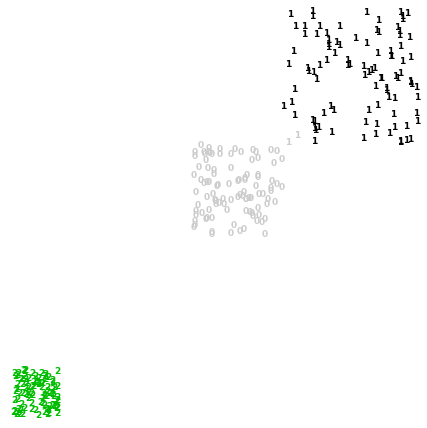

In [150]:
from sklearn.cluster import KMeans
#help(KMeans)
#%time

clustering = KMeans(init='random', n_clusters=3, n_init=2000)
labels_normal = clustering.fit_predict(normal2D)
labels_uniform = clustering.fit_predict(uniform2D)

plot_labeled_dataset(normal2D, normal2D_y, labels_normal)
plot_labeled_dataset(uniform2D, uniform2D_y, labels_uniform)

**Question 1**: The code above applies k-means to the datasets.
- Experiment with the three parameters and compare the quality of the clusterings.
- Which choice of parameters do you deem optimal? -- Why?
- What are reasonable a-priori estimates (bounds) for the number of clusters?
- What is the differences between stochastic and batch k-means?

 - [Comparison of the K-Means and MiniBatchKMeans](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#example-cluster-plot-mini-batch-kmeans-py)

**Answers/Hints for Question 1:** (highlight to view)

<font color="white">

- init 'kmeans++' (which spreads the starting points) is stictly better than init 'random', because we avoid bad initialisations which yield bad results if the iteration_number is low <br/>

- init, see above. n_clusters=3 (domain knowledge), <br/>

- If possible, have a look (!) at a projection to lower dimensions => lower bound for the number of clusters and thus a starting value for incremental search using evaluation measures (see below) <br/>

- Batch version first assigns all points to clusters before updating centroids - Stochastic version updates centroids after having assigned just a few points.
</font>


# Hierarchical Agglomerative Clustering

* Hierarchical Agglomerative Clustering forms a family of clustering algorithms that build hierarchically nested clusters
* The resulting tree is called a dendrogram
* Agglomerative means bottom up:
  - First, all data points form a single cluster
  - Second, nearest clusters are merged until only one cluster remains
* Critical is the distance measure between clusters (i.e. group of data samples)

### Usage in scikit-learn

Scikit implements the Hierarchical Agglomerative Clustering as follows.
* Module: `from sklearn.cluster import AgglomerativeClustering`
* Instantiate a object `clustering = AgglomerativeClustering(....parameters...)`
* Fit to data: `model = clustering.fit(data)`
* (Optional) Assign new data to cluster: `model.predict(data)`

The possible parameters for distance measure between the clusters are
- linkage='ward': Ward Criterion for variance-minimization of clusters
- linkage='average': average of distances between two sets
- linkage='complete': maximum of distances between two sets

Scikit also allows to add connectivity constraints, i.e. that cluster only merge with certain other samples. This can be helpful for image clustering when limiting clusters to form homogeneous regions in the image

### Project 2.2: Using HAC for Image Clustering

Below, you find code to examine the effect of linkage options for HAC, taken from [Ward Demo on the scikit-learn homepage](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). (Author: Gael Varoquaux, License: BSD 3 clause (C) INRIA 2014) It uses the [Digits Database](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) which contains ~1800 images (8x8) of digits with associated labels.

* Run the code below and try to understand what happens. (Several parts are merely dedicated to improving the presentation. First of all, you want to identify the part where the clustering takes place.)

complete : 0.57s
average : 0.54s
ward : 0.59s


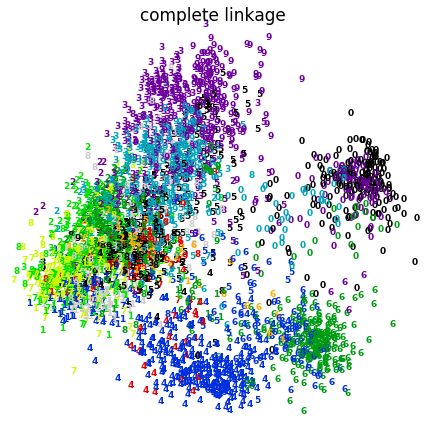

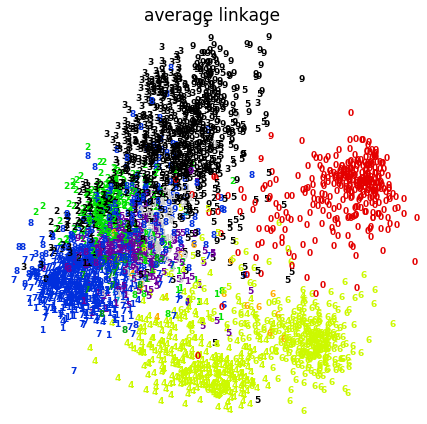

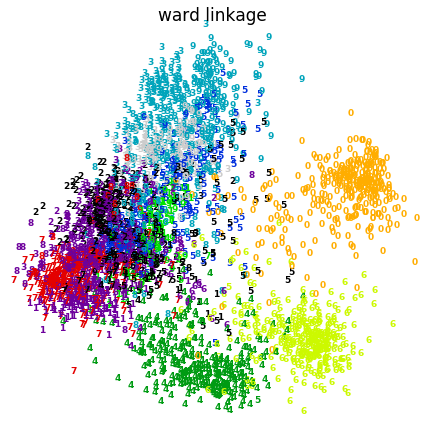

In [94]:
from sklearn.cluster import AgglomerativeClustering

from time import time
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets


def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


digits_X_l, digits_y_l = nudge_images(digits_X, digits_y)

for linkage in ('complete', 'average', 'ward'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(digits_X_l)
    print("%s : %.2fs" % (linkage, time() - t0))
    plot_labeled_dataset(digits_X_l, digits_y_l, clustering.labels_, "%s linkage" % linkage, proj=manifold.SpectralEmbedding)


**Question 2**: We want to understand the effect of the linkage strategies.

- Change the number of clusters (parameter `n_clusters` for `AgglomerativeClustering`). In case that you had only a rough guess for the number of digit classes, how would you approach choosing the number of clusters?
- Which linkage strategy seems to perform best and can you explain this from their definition.

**Hints/Answers to Question 2**: (highlight to view)

<font color="white">

- Eventually, the "best" number of clusters is *at least* the number of digits (because a single digit may occur in several unrelated clusters -- think two ways to spell 7). So, I'd suggest to start at the lower bound of your estimate and then increase in small increments.

- "Ward" is preferable, because instead of merely looking at distances, it also considers the "shape" (variance) of its clusters; it also avoids making an outlier a single cluster.

</font>

# DBScan - Density-based Clustering

* Density-based Clustering aims to find regions of high density that are separated via regions of low density.
* DBScan differentiates between noise points, core points and border points by defining an $\epsilon$ environment around a point $x_i$ in which a certain number of points must exists so that $x_i$ qualifies as core point
* Border points can be ambiguos, i.e. can belong to two differnt clusters where they fall in the $\epsilon$ region (but do not form a core point)

#### Usage in scikit learn

* Module: `from sklearn.cluster import DBSCAN`
* Instantiate a object `clustering = DBSCAN(....parameters...)`
* Fit to data: `model = clustering.fit(data)`

The implementation of the algorithm is non-deterministic, i.e. it is dependent on the order of the data. Core points of a cluster will be always assigned to the same cluster, but the cluster number might change depending which cluster core point is taken first.



### Project 2.3: Apply scikit-learn DBScan using Random Data

**Question 4**: In this exercise you should apply the scikit-learn DBSCAN algorithm and evaluate it visually on the above mentioned datasets.

- Read the documentation for the parameter settings and try different settings to better fit the algorithm to the data. How crucial is $\epsilon$? How does the clustering results compare to the k-means algorithm?
- How could you estimate $\epsilon$ and the number of points in the $\epsilon$ region?
- How well can you fit the parameter and where is the problem?

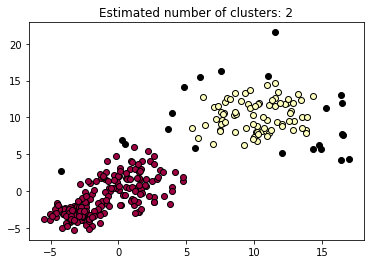

In [117]:
from sklearn.cluster import DBSCAN

def plot_dbscan(X, y, labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # Black removed and is used for noise instead.
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', c=col, markeredgecolor='k')

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', c=col, markeredgecolor='k')

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()


clustering = DBSCAN(eps=2, min_samples=10).fit(normal2D)
labels = clustering.labels_

plot_dbscan(normal2D, normal2D_y, labels)

**Hint/Answers to Question 4:** (highlight to view)
<font color="white">
- Oh well, for the left picture, DBSCAN has a hard time finding the three inherent clusters, since the density is different for the two on the left bottom (denser) in comparison to the one on the top right (sparser).
</font>

# Clustering Evaluation

The quality of clustering has to be measured, otherwise results can be abritrary (especially for high dimensional data where visualisation of clusters is not possible)

Cluster quality measure can be distinguished between

2. **External Validity Indices** that rely on a given correct assignment of points to groups
1. **Internal Validity Indices** that indicate the quality of the shape of an cluster without relying on the correct assignment of points to cluster

These measures are often used for finding the best parameters in a **relative validation**.

### Realisation in scikit-learn

Scikit learn implements a number of validity measures. See [the tutorial](http://scikit-learn.org/stable/modules/clustering.html#clustering) for an overview. 


### Precision and Recall

For a given class with label `a`, we can compute the precision and recall of our prediction.
- True Positives (TP): In the set of examples for which we predicted `a`, how many were in fact labeled `a`?
- False Positives (FP): In the set of examples for which we predicted `a`, how many were in fact not labeled `a`?
- True Negatives (TN): In the set of examples for which we did not predict `a`, how many were in fact not labeled `a`?
- False Negatives (FN): In the set of examples for which we did not predict `a`, how many were in fact labeled `a`?

$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$

$$FScore = 2 * \frac{Precision * Recall}{Precision + Recall}$$

In [145]:
labels_true = [0, 1, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 0, 1]

pr, re, fs, su = metrics.precision_recall_fscore_support(labels_true, labels_pred, warn_for=())
print("Precisions:", pr)
print("Recalls:", re)
print("F-Scores:", fs)
print("Support:", su)

Precisions: [ 0.33333333  0.66666667]
Recalls: [ 0.5  0.5]
F-Scores: [ 0.4         0.57142857]
Support: [2 4]


# Further References and Reading

- [Lecture Notes on the Course Machine Learning and Data Mining](http://www.uni-weimar.de/en/media/chairs/webis/teaching/lecturenotes/#machine-learning). 
- Pang-Ning Tan, Michael Steinbach, and Vipin Kumar, [Introduction to Data Mining](http://www.pearsonhighered.com/educator/academic/product/0,1144,0321321367,00.html), Addison-Wesley, 2006. ISBN 0-321-32136-7. 
- [Unsupervised learning: seeking representations of the data](http://scikit-learn.org/stable/tutorial/statistical_inference/unsupervised_learning.html), scikit-learn Tutorial.
